1. Introduction Générale
Le but de ce projet est de réaliser une analyse poussée des avis clients extraits du dataset Amazon, en explorant trois axes majeurs : le prétraitement des données textuelles, la détection de thèmes via des techniques de clustering et l’analyse des sentiments pour comprendre les émotions exprimées dans les avis.

2. Prétraitement des Données

In [1]:
import pandas as pd

# Lecture des fichiers
reviews = pd.read_json('reviews.jsonl', lines=True)
meta = pd.read_json('meta.jsonl', lines=True)

# Vérification des données
print(reviews.head())
print(reviews.info())




   rating                                title  \
0       4     No white background! It’s clear!   
1       5  Awesome!  Great price!  Works well!   
2       5   Worked but took an hour to install   
3       4                               Decent   
4       5                             LOVE IT!   

                                                text  \
0  I bought this bc I thought it had the nice whi...   
1  Perfect. How pissed am I that I recently paid ...   
2  Overall very happy with the end result. If you...   
3  Lasted about 9 months then the lock button bro...   
4  LOVE THIS CASE! Works better than my expensive...   

                                              images        asin parent_asin  \
0  [{'small_image_url': 'https://images-na.ssl-im...  B08L6L3X1S  B08L6L3X1S   
1                                                 []  B079BPGF6C  B079BPGF6C   
2  [{'small_image_url': 'https://m.media-amazon.c...  B088DR7Z5B  B0BBGGC8F2   
3  [{'small_image_url': 'https://images-na

In [2]:
import spacy

# Install the spaCy model
!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

doc = nlp("This is a sample review about a phone. It's amazing!")
tokens = [token.text for token in doc]
print(tokens)


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.2/12.8 MB 4.8 MB/s eta 0:00:03
     -- ------------------------------------- 0.7/12.8 MB 7.8 MB/s eta 0:00:02
     --- ------------------------------------ 1.2/12.8 MB 8.6 MB/s eta 0:00:02
     ----- ---------------------------------- 1.7/12.8 MB 9.7 MB/s eta 0:00:02
     ------ --------------------------------- 2.0/12.8 MB 8.5 MB/s eta 0:00:02
     ------- -------------------------------- 2.5/12.8 MB 9.3 MB/s eta 0:00:02
     --------- ------------------------------ 3.0/12.8 MB 9.6 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 9.3 MB/s eta 0:00:02
     ------------ --------------------------- 4.0/12.8 MB 9.7 MB/s eta 0:00:01
     -------------- ------------------------- 4.5/12.8 MB 9.9 MB/s eta 0:00:01
     --------------- ------------------------ 4.9/12.8 MB 9.8 MB/s eta 0:00:01
     ---------------- ----------------------- 5.4/12.8 MB 9


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


['This', 'is', 'a', 'sample', 'review', 'about', 'a', 'phone', '.', 'It', "'s", 'amazing', '!']


Traitement des valeurs manquantes :

In [3]:
# Remplacer les valeurs manquantes
reviews.fillna("", inplace=True)

Pipeline complet de SpaCy :

In [4]:
import spacy
import json

nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

# Prétraitement
reviews['processed'] = reviews['text'].apply(preprocess)

# Sauvegarde des données prétraitées
with open('processed_reviews.json', 'w') as f:
    json.dump(reviews['processed'].tolist(), f)


Ajout : Visualisation des tokens les plus fréquents

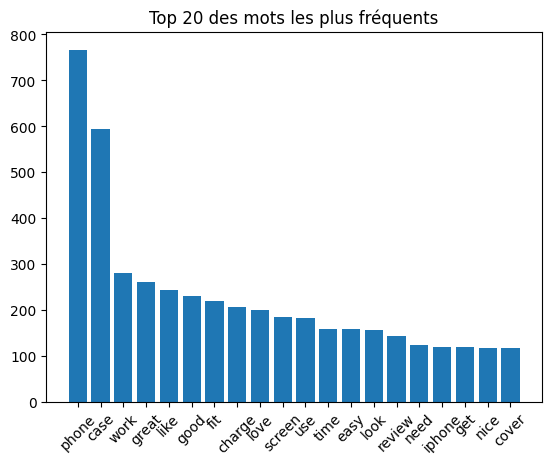

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Comptage des mots
all_tokens = [token for doc in reviews['processed'] for token in doc]
token_counts = Counter(all_tokens)

# Top 20 des mots les plus fréquents
most_common = token_counts.most_common(20)
words, counts = zip(*most_common)

# Visualisation
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 des mots les plus fréquents')
plt.show()


3. Clustering des Avis

Embeddings avancés avec SentenceTransformers :

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(reviews['processed'].apply(' '.join).tolist())


Code : Application de KMeans
Clustering avec évaluation des performances :

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Calcul du Silhouette Score
silhouette = silhouette_score(embeddings, labels)
print(f"Silhouette Score: {silhouette}")


c:\Users\soso8\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.048170607537031174


In [8]:
from collections import defaultdict

# Associer les avis aux clusters
clusters = defaultdict(list)
for idx, label in enumerate(labels):
    clusters[label].append(reviews['processed'][idx])

# Afficher les mots-clés de chaque cluster
for cluster_id, docs in clusters.items():
    words = [word for doc in docs for word in doc]
    common_words = Counter(words).most_common(10)
    print(f"Cluster {cluster_id}: {common_words}")


Cluster 4: [('phone', 249), ('screen', 124), ('work', 97), ('use', 72), ('like', 65), ('protector', 61), ('easy', 57), ('good', 51), ('great', 50), ('time', 49)]
Cluster 3: [('charge', 181), ('work', 95), ('phone', 95), ('charger', 89), ('cable', 66), ('time', 55), ('need', 50), ('use', 47), ('long', 46), ('good', 42)]
Cluster 1: [('case', 526), ('phone', 388), ('fit', 102), ('great', 89), ('good', 89), ('like', 88), ('love', 83), ('cover', 77), ('look', 75), ('protect', 66)]
Cluster 2: [('great', 57), ('work', 47), ('love', 46), ('good', 28), ('like', 24), ('product', 24), ('time', 19), ('nice', 17), ('look', 16), ('buy', 16)]
Cluster 0: [('fit', 77), ('band', 67), ('phone', 34), ('watch', 33), ('like', 25), ('look', 24), ('great', 23), ('easy', 21), ('good', 19), ('review', 15)]


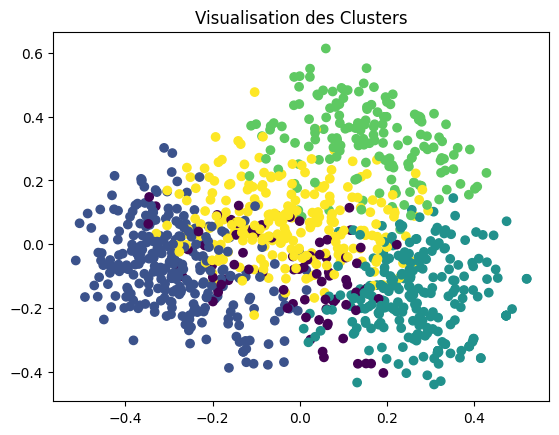

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Réduction de dimensions pour visualisation
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Affichage des clusters
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis')
plt.title('Visualisation des Clusters')
plt.show()


In [12]:
from transformers import pipeline

# Charger le modèle de sentiment
sentiment_model = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

# Analyse des sentiments
reviews['sentiment'] = reviews['text'].apply(lambda x: sentiment_model(x[:512])[0]['label'])


In [13]:
from scipy.stats import pearsonr

# Conversion des sentiments en scores numériques
sentiment_scores = reviews['sentiment'].apply(lambda x: int(x[0]))
correlation, _ = pearsonr(reviews['rating'], sentiment_scores)
print(f"Correlation entre les notes réelles et prédictions: {correlation}")


Correlation entre les notes réelles et prédictions: 0.8086371560867782


In [15]:
#calcul de la précision
accuracy = (sentiment_scores == reviews['rating']).mean()
print(f"Précision: {accuracy}")

Précision: 0.64


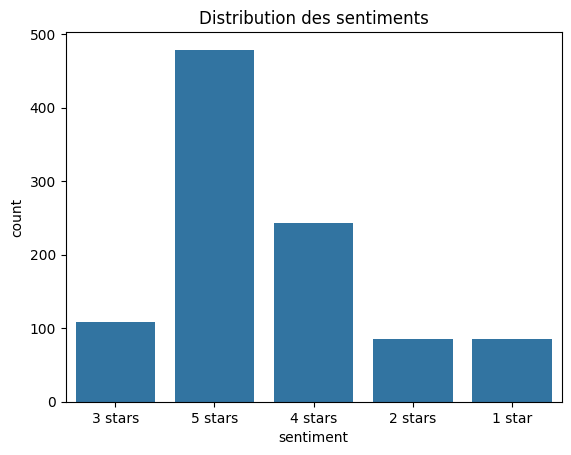

In [ ]:
# Distribution des sentiments
sns.countplot(x='sentiment', data=reviews)
plt.title('Distribution des sentiments')
plt.show()


1. Expérimentation : Essayez d'autres modèles de sentiment disponibles sur Hugging Face
Objectif :
Comparer plusieurs modèles de sentiment pour choisir celui qui offre les résultats les plus pertinents.

Étapes :
Choisir un ou deux modèles alternatifs sur Hugging Face.
Comparer leurs prédictions avec celles du modèle initial.

In [ ]:
from transformers import pipeline

# Charger le modèle initial
model_1 = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

# Charger un modèle alternatif
model_2 = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

# Comparer les prédictions
reviews['sentiment_model_1'] = reviews['text'].apply(lambda x: model_1(x[:512])[0]['label'])
reviews['sentiment_model_2'] = reviews['text'].apply(lambda x: model_2(x[:512])[0]['label'])

# Afficher les comparaisons
print(reviews[['text', 'sentiment_model_1', 'sentiment_model_2']].head(10))



                                                text sentiment_model_1  \
0  I bought this bc I thought it had the nice whi...           3 stars   
1  Perfect. How pissed am I that I recently paid ...           5 stars   
2  Overall very happy with the end result. If you...           4 stars   
3  Lasted about 9 months then the lock button bro...           2 stars   
4  LOVE THIS CASE! Works better than my expensive...           5 stars   
5  This item works great with my IPhone 13 with M...           5 stars   
6  Item came as described! Fast shipping & east t...           5 stars   
7   Stocking stuffers for my boys & they liked them.           5 stars   
8  My son loves his camo case! It is a great valu...           5 stars   
9  These work. It is a little difficult to get th...           4 stars   

  sentiment_model_2  
0          POSITIVE  
1          NEGATIVE  
2          POSITIVE  
3          NEGATIVE  
4          POSITIVE  
5          POSITIVE  
6          NEGATIVE  
7        

In [ ]:
from scipy.stats import pearsonr

# Conversion des sentiments en scores numériques
# Modèle 2
sentiment_scores_2 = reviews['sentiment_model_2'].apply(lambda x: int(x[0]))
correlation_2, _ = pearsonr(reviews['rating'], sentiment_scores_2)
print(f"Correlation entre les notes réelles et prédictions (Modèle 2): {correlation_2}")

ValueError: invalid literal for int() with base 10: 'P'

2. Visualisation : Distribution des notes réelles et prédites
Objectif :
Comparer les notes réelles données par les clients (extraites des données) avec les notes de sentiment prédites par le modèle.

Étapes :
Convertir les sentiments en scores numériques (1-5 étoiles).
Comparer la distribution des notes réelles avec celles prédites.

In [ ]:
# Convertir les prédictions du modèle initial en scores numériques
sentiment_map = {
    '1 star': 1, '2 stars': 2, '3 stars': 3, '4 stars': 4, '5 stars': 5,
    'NEGATIVE': 1, 'POSITIVE': 5  # Pour un modèle binaire comme DistilBERT
}
reviews['sentiment_score_model_1'] = reviews['sentiment_model_1'].map(sentiment_map)
reviews['sentiment_score_model_2'] = reviews['sentiment_model_2'].map(sentiment_map)


Distribution des notes réelles

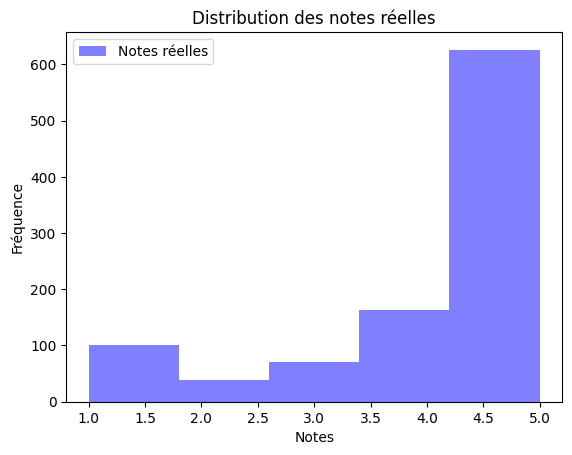

In [ ]:
import matplotlib.pyplot as plt

# Histogramme des notes réelles
plt.hist(reviews['rating'], bins=5, alpha=0.5, label='Notes réelles', color='blue')
plt.title('Distribution des notes réelles')
plt.xlabel('Notes')
plt.ylabel('Fréquence')
plt.legend()
plt.show()


Comparaison des distributions

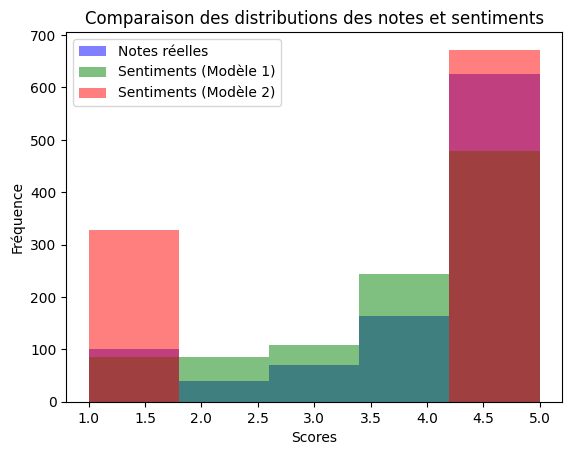

In [ ]:
# Histogrammes des notes réelles et prédites
plt.hist(reviews['rating'], bins=5, alpha=0.5, label='Notes réelles', color='blue')
plt.hist(reviews['sentiment_score_model_1'], bins=5, alpha=0.5, label='Sentiments (Modèle 1)', color='green')
plt.hist(reviews['sentiment_score_model_2'], bins=5, alpha=0.5, label='Sentiments (Modèle 2)', color='red')
plt.title('Comparaison des distributions des notes et sentiments')
plt.xlabel('Scores')
plt.ylabel('Fréquence')
plt.legend()
plt.show()
